# Implementation Paper Journal

# Multi-classification Assessment of Bank Personal Credit Risk Based on Multi-source Information Fusion

This notebook implements the methods described in the paper: 

"Multi-classification assessment of bank personal credit risk based on multi-source information fusion"

By Tianhui Wang, Renjing Liu, Guohua Qi

Reference: Expert Systems With Applications 191 (2022) 116236

# Introduction

The paper proposes a new multi-classification assessment model for personal credit risk based on the theory of information fusion (MIFCA) using six machine learning algorithms. The MIFCA model integrates the advantages of multiple classifiers and reduces the interference of uncertain information through Dempster-Shafer (D-S) evidence theory. The key contributions of the paper are:

- Constructing a new multi-classification credit assessment model to provide more accurate five-classification credit assessments compared to traditional binary classifications.

- Innovatively fusing six different types of classifiers using D-S evidence theory to reduce uncertainty and improve overall accuracy and robustness.

- Creating a model with fewer parameters to enhance efficiency and usability, suitable for big data applications

- Verifying the assessment performance of MIFCA on real datasets and comparing it with classic statistical and machine learning approaches.

# Objective

Our goal is to replicate the MIFCA model as described in the paper using the provided dataset. We will:

- Preprocess the data, handling missing values, outliers, and encoding categorical variables.

- Train six base classifiers: Decision Tree (DT), Random Forest (RF), Support Vector Machine (SVM), K-Nearest Neighbors (KNN), BP Neural Network (implemented as Multi-Layer Perceptron), and XGBoost.

- Implement Dempster-Shafer evidence theory to fuse the outputs of these classifiers.

- Evaluate the performance of the fused model and compare it with individual classifiers.

# Implementation

## Import Necessary Libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For Progress Bar
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Ensure numpy arrays are contiguous
import numpy as np

# Check versions (optional)
import sklearn
print("Scikit-learn version:", sklearn.__version__)
import numpy
print("NumPy version:", numpy.__version__)

Scikit-learn version: 1.3.0
NumPy version: 1.23.5


## 1. Data Loading and Preprocessing

### 1.1 Load the Dataset

Assuming your dataset is in the data folder and named `Dataset-Research.xlsx`

In [5]:
# Load the dataset
data = pd.read_excel('data/Dataset-Research.xlsx', header=1)

# Display the first few rows
data.head()

,Customer ID,Type of Loan Business,Guarantee the Balance,Account Connection Amount,Security Guarantee Amount,Five-level Classification,Whether Interest is Owed,Whether Self-service Loan,Type of Guarantee,Safety Coefficient,...,Whether Interest is Owed (regulatory standard),Repayment Type,Installment Repayment Method (numerical type),Installment Repayment Method (discrete type),Installment Repayment Cycle (numerical type),Repayment Cycle (discrete type),Number of Houses,Month Property Costs,Family Monthly Income,Five Categories
0,1,Personal Housing Mortgage Loan (First hand),850000.00,850000.00,85000000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,1.0,343.84,15000.00,Normal
1,2,Personal Housing Mortgage Loan (First hand),2143810.46,2143810.46,171504836.8,A1,N,N,Average house,80.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,1.0,342.55,19700.00,Normal
2,3,Personal Commercial Housing Mortgage Loan (Fir...,892500.00,892500.00,89250000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,NaN,282.00,39678.00,Normal
3,4,Housing accumulation fund loan 3,NaN,NaN,NaN,A1,N,N,General Enterprise Guarantee,NaN,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,3490.00,Normal
4,5,Personal Commercial Housing Mortgage Loan (Fir...,606400.45,606400.45,60640045.0,A1,N,N,Average house,100.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,51502.56,Normal


### 1.2 Preliminary Exploration of Data Structures

In [6]:
# Check the shape of the dataset
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

# List all columns
print("Columns in the dataset:")
print(data.columns.tolist())

The dataset contains 27522 rows and 28 columns.
Columns in the dataset:
['Customer ID', 'Type of Loan Business', 'Guarantee the Balance', 'Account Connection Amount', 'Security Guarantee Amount', 'Five-level Classification', 'Whether Interest is Owed', 'Whether Self-service Loan', 'Type of Guarantee', 'Safety Coefficient', 'Collateral Value (yuan)', 'Guarantee Method', 'Date Code', 'Approval Deadline', 'Whether Devalue Account', 'Industry Category', 'Down Payment Amount', 'Whether Personal Business Loan', 'Whether Interest is Owed (regulatory standard)', 'Repayment Type', 'Installment Repayment Method (numerical type)', 'Installment Repayment Method (discrete type)', 'Installment Repayment Cycle (numerical type)', 'Repayment Cycle (discrete type)', 'Number of Houses', 'Month Property Costs', 'Family Monthly Income', 'Five Categories']


### 1.3 Data Cleaning

#### 1.3.1 Remove Irrelevant or Redundant Variables

Based on the description, we need to drop certain columns that are either irrelevant or redundant.

In [7]:
# List of columns to drop
columns_to_drop = [
    'Customer ID',  # Irrelevant
    'Account Connection Amount',  # Redundant
    'Security Guarantee Amount',  # Redundant
    'Whether Interest is Owed',  # Duplicate information
    'Whether Self-service Loan',  # Only one value
    'Type of Guarantee',  # Duplicate with 'Guarantee Method'
    'Date Code',  # Duplicate with 'Approval Deadline'
    'Repayment Type',  # Similar to 'Installment Repayment Method'
    'Installment Repayment Cycle (numerical type)',  # Only one value
    'Repayment Cycle (discrete type)',  # Only one value
    'Industry Category',  # Too many missing values
    'Whether Personal Business Loan',  # Irrelevant
    'Installment Repayment Method (discrete type)'  # Duplicate with 'Installment Repayment Method (numerical type)'
]

# Drop the columns
data.drop(columns=columns_to_drop, inplace=True)

# Verify the remaining columns
print("Remaining columns after dropping:")
print(data.columns.tolist())

Remaining columns after dropping:
['Type of Loan Business', 'Guarantee the Balance', 'Five-level Classification', 'Safety Coefficient', 'Collateral Value (yuan)', 'Guarantee Method', 'Approval Deadline', 'Whether Devalue Account', 'Down Payment Amount', 'Whether Interest is Owed (regulatory standard)', 'Installment Repayment Method (numerical type)', 'Number of Houses', 'Month Property Costs', 'Family Monthly Income', 'Five Categories']


#### 1.3.2 Handle Missing Values

In [8]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Type of Loan Business                                0
Guarantee the Balance                              304
Five-level Classification                            0
Safety Coefficient                                 304
Collateral Value (yuan)                            322
Guarantee Method                                   304
Approval Deadline                                    0
Whether Devalue Account                              0
Down Payment Amount                                620
Whether Interest is Owed (regulatory standard)       0
Installment Repayment Method (numerical type)      757
Number of Houses                                  4571
Month Property Costs                              1286
Family Monthly Income                               20
Five Categories                                      0
dtype: int64


Impute Missing Values

Since dropping all rows with missing values would significantly reduce the dataset size, we'll impute missing values.

In [9]:
# Impute Numerical Columns
# List of numerical columns with missing values
numerical_cols_with_na = ['Guarantee the Balance', 'Safety Coefficient', 'Collateral Value (yuan)', 
                          'Down Payment Amount', 'Number of Houses', 'Installment Repayment Method (numerical type)',
                          'Month Property Costs', 'Family Monthly Income']

# Impute numerical columns with mean
imputer_num = SimpleImputer(strategy='mean')
data[numerical_cols_with_na] = imputer_num.fit_transform(data[numerical_cols_with_na])

In [10]:
 # Impute Categorical Columns
 # List of categorical columns with missing values
categorical_cols_with_na = ['Guarantee Method']

# Impute categorical columns with mode
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_cols_with_na] = imputer_cat.fit_transform(data[categorical_cols_with_na])

In [11]:
# Check for missing values after imputation
print("Missing values after imputation:")
print(data.isnull().sum())

Missing values after imputation:
Type of Loan Business                             0
Guarantee the Balance                             0
Five-level Classification                         0
Safety Coefficient                                0
Collateral Value (yuan)                           0
Guarantee Method                                  0
Approval Deadline                                 0
Whether Devalue Account                           0
Down Payment Amount                               0
Whether Interest is Owed (regulatory standard)    0
Installment Repayment Method (numerical type)     0
Number of Houses                                  0
Month Property Costs                              0
Family Monthly Income                             0
Five Categories                                   0
dtype: int64


#### 1.3.3 Handle Outliers

In [12]:
# Remove outliers in 'Month Property Costs' less than 20 or greater than 20000
data = data[(data['Month Property Costs'] >= 20) & (data['Month Property Costs'] <= 20000)]

# Remove outliers in 'Family Monthly Income' less than 1500
data = data[data['Family Monthly Income'] >= 1500]

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

### 1.4 Data Transformation

We need to encode categorical variables into numerical ones.

In [13]:
# List of categorical variables to encode
categorical_vars = ['Type of Loan Business', 'Guarantee Method', 'Whether Devalue Account',
                    'Whether Interest is Owed (regulatory standard)', 'Five-level Classification', 'Five Categories']

# Use LabelEncoder for binary variables and OneHotEncoder for variables with more than two categories
label_encoder = LabelEncoder()

# Binary variables
binary_vars = ['Whether Devalue Account', 'Whether Interest is Owed (regulatory standard)']
for var in binary_vars:
    data[var] = label_encoder.fit_transform(data[var])

# For 'Five Categories', which is our target variable, encode it
data['Five Categories'] = label_encoder.fit_transform(data['Five Categories'])

# One-hot encode 'Type of Loan Business' and 'Guarantee Method'
data = pd.get_dummies(data, columns=['Type of Loan Business', 'Guarantee Method'], drop_first=True)

# Drop 'Five-level Classification' as it is not needed
data.drop('Five-level Classification', axis=1, inplace=True)


### 1.5 Data Splitting

Although the Pearson correlation coefficients are low to medium, we will keep all variables as they may contribute to the model.

In [14]:
# Separate features and target
X = data.drop('Five Categories', axis=1)
y = data['Five Categories']

### 1.6 Processing of Imbalanced Data Sets

#### 1.6.1 Check for Missing Values in X Before SMOTE

In [15]:
# Verify no missing values in features
print("Checking for missing values in features:")
print(X.isnull().sum().sum())

Checking for missing values in features:
0


#### 1.6.2 Proceed with SMOTE

In [16]:
# Split into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the distribution of target variable before SMOTE
print("Distribution of target variable before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after SMOTE
print("Distribution of target variable after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Distribution of target variable before SMOTE:
Five Categories
2    20321
3     1150
1      252
0       87
4       82
Name: count, dtype: int64
Distribution of target variable after SMOTE:
Five Categories
2    20321
3    20321
1    20321
0    20321
4    20321
Name: count, dtype: int64


### 1.6.3 Visualize Class Distribution Before and After SMOTE

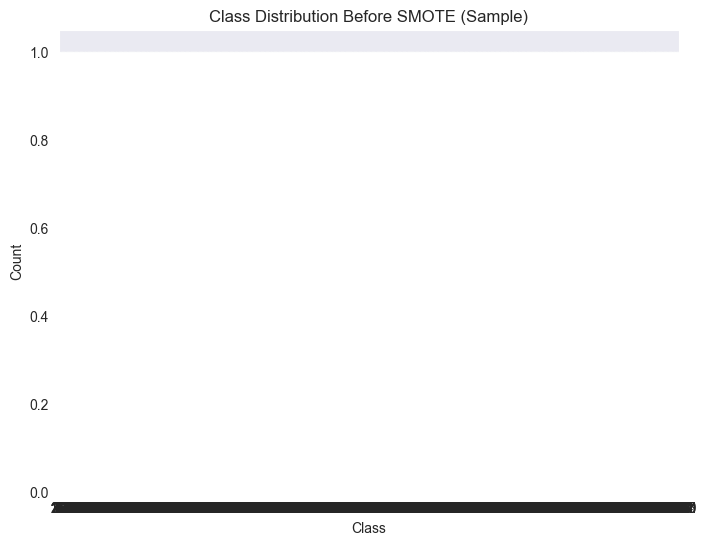

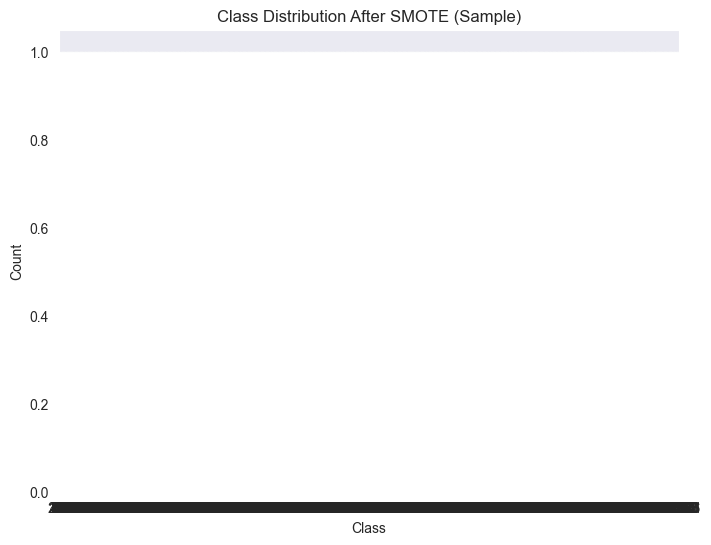

Class distribution before SMOTE:
Five Categories
2    0.928239
3    0.052531
1    0.011511
0    0.003974
4    0.003746
Name: proportion, dtype: float64

Class distribution after SMOTE:
Five Categories
2    0.2
3    0.2
1    0.2
0    0.2
4    0.2
Name: proportion, dtype: float64


In [17]:
# Sample size (adjust this value as needed)
sample_size = 1000

# Before SMOTE
y_train_sample = y_train.sample(n=sample_size, random_state=42)
plt.figure(figsize=(8,6))
sns.countplot(y_train_sample)
plt.title('Class Distribution Before SMOTE (Sample)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# After SMOTE
y_train_resampled_sample = pd.Series(y_train_resampled).sample(n=sample_size, random_state=42)
plt.figure(figsize=(8,6))
sns.countplot(y_train_resampled_sample)
plt.title('Class Distribution After SMOTE (Sample)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Print class distributions
print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

### 1.7 Standardize Numerical Features

In [18]:
# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Standardize the numerical features
scaler = StandardScaler()
X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Ensure data is in numpy array and data types are correct
X_train_resampled = np.ascontiguousarray(X_train_resampled)
X_test = np.ascontiguousarray(X_test)

## 2. Train Base Classifiers

### 2.1 Decision Tree Classifier

In [19]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
dt_probs = dt_model.predict_proba(X_test)

### 2.2 Random Forest Classifier

In [20]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
rf_probs = rf_model.predict_proba(X_test)

### 2.3 Support Vector Machine

In [21]:
# Train SVM
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
svm_probs = svm_model.predict_proba(X_test)

### 2.4 K-Nearest Neighbors

In [22]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)

X_test_array = np.ascontiguousarray(X_test)

# Predict using KNN
knn_pred = knn_model.predict(X_test_array)
knn_probs = knn_model.predict_proba(X_test_array)

### 2.5 BP Neural Network (MLPClassifier)

In [23]:
# Train BP Neural Network
bp_model = MLPClassifier(random_state=42, max_iter=300)
bp_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
bp_probs = bp_model.predict_proba(X_test)

### 2.6 XGBoost Classifier

In [24]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
xgb_probs = xgb_model.predict_proba(X_test)

## 3. D-S Evidence Theory Fusion

### 3.1 Defining the MassFunction Class

In [25]:
# Define the MassFunction class
class MassFunction:
    def __init__(self, mass_dict):
        self.mass = {}
        total_mass = 0
        for hypothesis, mass_value in mass_dict.items():
            hypothesis = frozenset([hypothesis])
            self.mass[hypothesis] = mass_value
            total_mass += mass_value
        if total_mass != 1:
            for hypothesis in self.mass:
                self.mass[hypothesis] /= total_mass

    def combine_conjunctive(self, other):
        new_mass = {}
        conflict_mass = 0
        for h1, m1 in self.mass.items():
            for h2, m2 in other.mass.items():
                intersection = h1 & h2
                if intersection:
                    new_mass[intersection] = new_mass.get(intersection, 0) + m1 * m2
                else:
                    conflict_mass += m1 * m2
        total_mass = sum(new_mass.values())
        if total_mass == 0:
            return MassFunction({frozenset(): 1})
        else:
            for h in new_mass:
                new_mass[h] /= (1 - conflict_mass)
            return MassFunction(new_mass)
    
    def max_belief(self):
        max_mass = 0
        best_hypothesis = None
        for h, m in self.mass.items():
            if m > max_mass:
                max_mass = m
                best_hypothesis = h
        return best_hypothesis

### 3.2 Prepare Belief Assignments

In [26]:
# Number of classes
classes = list(dt_model.classes_)  # Convert numpy array to list
classes = [int(cls) for cls in classes]  # Ensure classes are integers
num_classes = len(classes)

# Initialize list to store mass functions for each classifier
mass_functions_list = []

# List of probabilities from classifiers
probs_list = [dt_probs, rf_probs, svm_probs, knn_probs, bp_probs, xgb_probs]

# For each classifier, create mass functions for each instance
for probs in probs_list:
    mass_functions = []
    for prob in probs:
        mass = {}
        for i, cls in enumerate(classes):
            mass[cls] = prob[i]  # cls is now an integer
        mass_functions.append(MassFunction(mass))
    mass_functions_list.append(mass_functions)

### 3.3 Combine Mass Functions Using Dempster's Rule

In [27]:
# Initialize list to store fused predictions
fused_predictions = []

# Iteration through each instance
for i in tqdm(range(len(X_test))):
    # Get mass functions for each classifier
    mass_functions = [mass_functions_list[j][i] for j in range(len(mass_functions_list))]
    
    # Combine mass functions using Dempster's rule
    combined_mass = mass_functions[0]
    for mf in mass_functions[1:]:
        combined_mass = combined_mass.combine_conjunctive(mf)
    
    # Decide the class with the highest belief
    predicted_hypothesis = combined_mass.max_belief()
    # Ensure predicted_hypothesis is not empty
    if predicted_hypothesis and len(predicted_hypothesis) > 0:
        predicted_class = list(predicted_hypothesis)[0]
        fused_predictions.append(predicted_class)  # Convert to integer
    else:
        # Handle the case when no hypothesis has mass
        # Choose the class with the highest total mass from combined_mass
        if combined_mass.mass:
            # Get the hypothesis with the highest mass
            predicted_class = max(combined_mass.mass.items(), key=lambda x: x[1])[0]
            # Extract the class label
            predicted_class = list(predicted_class)[0]
            fused_predictions.append(predicted_class)
        else:
            # As a last resort, append the majority class from training data
            majority_class = y_train_resampled.value_counts().idxmax()
            fused_predictions.append(int(majority_class))

100%|██████████| 5474/5474 [00:00<00:00, 23163.69it/s]


## 4. Evaluation of the Model's Performance

### 4.1 Evaluate Base Classifiers

In [28]:
# Function to evaluate and print metrics
def evaluate_model(model_name, y_true, y_pred):
    print(f"Performance {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("-" * 60)

# Predictions from base classifiers
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
knn_pred = knn_model.predict(X_test_array)  # Use the corrected X_test_array
bp_pred = bp_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluate each model
evaluate_model("Decision Tree", y_test, dt_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("SVM", y_test, svm_pred)
evaluate_model("KNN", y_test, knn_pred)
evaluate_model("BP Neural Network", y_test, bp_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

Performance Decision Tree:
Accuracy: 0.8854585312385824
Precision (macro): 0.667750537664523
Recall (macro): 0.7634413508794873
F1-score (macro): 0.6966788076794502

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.59      0.41        22
           1       0.91      0.94      0.92        63
           2       0.97      0.91      0.94      5081
           3       0.25      0.53      0.34       287
           4       0.90      0.86      0.88        21

    accuracy                           0.89      5474
   macro avg       0.67      0.76      0.70      5474
weighted avg       0.93      0.89      0.90      5474

------------------------------------------------------------
Performance Random Forest:
Accuracy: 0.9364267446108878
Precision (macro): 0.7227618694803261
Recall (macro): 0.7406138481493342
F1-score (macro): 0.7302054570688111

Classification Report:
              precision    recall  f1-score   support

           0    

### 4.2 Evaluate the MIFCA Model

In [29]:
# Function to extract labels from predictions
def extract_label(pred):
    if isinstance(pred, (frozenset, set)):
        # Flatten any nested frozensets or sets
        labels = list(pred)
        while any(isinstance(lbl, (frozenset, set)) for lbl in labels):
            new_labels = []
            for lbl in labels:
                if isinstance(lbl, (frozenset, set)):
                    new_labels.extend(list(lbl))
                else:
                    new_labels.append(lbl)
            labels = new_labels
        # Now labels should be a list of integers
        if len(labels) == 1:
            return labels[0]
        else:
            # If multiple labels, choose the one with the highest mass or handle as needed
            return labels[0]  # For simplicity, pick the first
    else:
        # Assume it's an integer or compatible type
        return pred

# Process fused_predictions to extract labels
processed_predictions = []
for pred in fused_predictions:
    pred_label = extract_label(pred)
    processed_predictions.append(pred_label)

# Convert to numpy array
fused_predictions_array = np.array(processed_predictions)

# Ensure y_test and fused_predictions_array have the same data type
if fused_predictions_array.dtype != y_test.dtype:
    fused_predictions_array = fused_predictions_array.astype(y_test.dtype)

# Evaluate the fused model
evaluate_model("MIFCA Model", y_test, fused_predictions_array)

IndexError: list index out of range

### 4.3 Confusion Matrix Heat Maps

In [1]:
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    class_names = [str(cls) for cls in classes]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Confusion matrix for MIFCA model
cm = confusion_matrix(y_test, fused_predictions)
plot_confusion_matrix(cm, classes=classes, title='Confusion Matrix for MIFCA Model')

NameError: name 'confusion_matrix' is not defined

## 5. Results and Analysis

### 5.1 Confusion Matrix for each models

In [ ]:
models = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'BP Neural Network', 'XGBoost', 'MIFCA Model']
predictions = [dt_pred, rf_pred, svm_pred, knn_pred, bp_pred, xgb_pred, fused_predictions]

for model_name, y_pred in zip(models, predictions):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=classes, title=f'Confusion Matrix for {model_name}')

### 5.2 Visualization Feature Importance from Random Forest

In [ ]:
# Show 10 feature importance from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

### 5.3 Visualization Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train_resampled, y_train_resampled, cv=5

## 5. Conclusion